(constant_updraft_2)=
# Update: Parcel model compute additional variables

I've added two problems to the Thursday worksheet that show how to compute additonal quantities about the parcel integration using pandas.DataFrame.apply

In [1]:
from pathlib import Path
import numpy as np
from a405.dropgrow.aerolib import lognormal,create_koehler
from a405.utils.helper_funs import make_tuple, find_centers
from a405.thermo.thermlib import find_esat
from a405.thermo.rootfinder import find_interval, fzero
from a405.dropgrow.drop_grow import find_diff
from a405.thermo.constants import constants as c
from scipy.integrate import odeint
import pandas as pd
from matplotlib import pyplot as plt

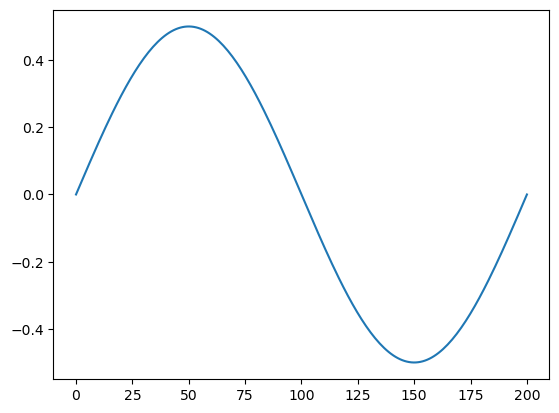

In [2]:
def find_wvel(the_time):
    period = 2*np.pi/200.
    wvel = 0.5*np.sin(the_time*period)
    return wvel
    
times = np.linspace(0,200,200)
wvel_out = [find_wvel(the_time) for the_time in times]
plt.plot(times,wvel_out);

## Library functions from the week 10 koehler worksheet

Move functions from {ref}`koehler2` into the a405 libraries

- a405.utils.helper_funs.make_tuple
- a405.utils.helper_funs.find_centers
- a405.dropgrow.aerolib.lognormal
- a405.dropgrow.aerolib.create_koehler
- a405.dropgrow.drop_grow.find_diff

## new functions for droplet growth

Calculate the liquid water content, supersaturation and the derivatives for the drop sizes

In [3]:
def rlcalc(var_vec,cloud_tup):
    """
    calculate the liquid water for the distribution

    the last  3 variables in var_vec are temperature, pressure and height (mks)

    Parameters
    ----------

    var_vec: vector(float)
           vector of values to be integrated
    cloud_top: namedtuple
           tuple of necessary coefficients
    """
    wl=cloud_tup.ndist*(var_vec[:-3]**3.)
    wl=np.sum(wl)
    wl=wl*4./3.*np.pi*c.rhol
    return wl

In [4]:
def Scalc(var_vec,cloud_tup):
    """
    calculate the environmental saturation using conservation
    of total water mixing ratio cloud_top.rt and the current
    value of the liquid water mixing ratio rl

    That is diagnosing the vapor mixing ratio as the difference
    between the total water in the parcel and the liquid water
    in the droplets

    the last  3 variables in var_vec are temperature, pressure and height (mks)

    Parameters
    ----------

    var_vec: vector(float)
        vector of values to be integrated

    cloud_top: namedtuple
           tuple of necessary coefficients

    Returns
    -------

    Sout: float
       environmental saturation

    """
    temp,press,height = var_vec[-3:]
    rl=rlcalc(var_vec,cloud_tup)
    rv=cloud_tup.rt - rl
    e=rv*press/(c.eps + rv)
    Sout=e/find_esat(temp)
    return Sout

In [5]:
def rlderiv(var_vec,deriv_vec,cloud_tup,nvars=3):
    """
    calculate the time derivative of the liquid water content
    using drop_grow.pdf eqn 21b

    the last  3 variables in var_vec are temperature, pressure and height (mks)
    
    Parameters
    ----------

    var_vec: vector(float)
        vector of values to be integrated

    deriv_vec: vector(float)
         derivatives of each of var_vec members

    cloud_tup: namedtuple
           tuple of input coefficients

    nvars:  int
        number of bulk thermodynamic variables (i.e. number of variables
        that are not droplet radii)

    Returns
    -------

    drldt: float
         rate of change of rl
    """
    #
    # the slice [:-nvars] gives only the droplet radii
    #
    rlderiv=(var_vec[:-nvars])**2.
    rlderiv=cloud_tup.ndist*rlderiv
    rlderiv=rlderiv*deriv_vec[:-nvars]
    drldt = np.sum(rlderiv)*4.*np.pi*c.rhol
    return drldt

In [6]:
def find_derivs(var_vec,the_time,cloud_tup):
    """
    calcuate derivatives of var_vec 

    

    Parameters
    ----------

    var_vec: vector(float)
        vector of values to be integrated

    the_time: float
       timestep 

    cloud_tup: namedtuple
           tuple of necessary coefficients
    

    Returns
    -------

    deriv_vec: vector(float)
         derivatives of each of var_vec
    
    """
    def find_wvel(the_time):
        period = 2*np.pi/200.
        wvel = 0.5*np.sin(the_time*period)
        return wvel

    the_wvel = find_wvel(the_time)
    #print('inside: ',var_vec)
    #print(f"{the_time=}")
    temp,press,height = var_vec[-3:]
    numrads = len(var_vec) - 3
    dry_radius = cloud_tup.dry_radius
    rho=press/(c.Rd*temp)
    #
    # find the evironmental S by water balance
    #
    S=Scalc(var_vec,cloud_tup)
    deriv_vec=np.zeros_like(var_vec)
    #dropgrow notes equation 18 
    for i in range(numrads):
        m=cloud_tup.masses[i]
        if var_vec[i] < dry_radius[i]:
            var_vec[i] = dry_radius[i]
        Seq=cloud_tup.koehler_fun(var_vec[i],m)  
        rhovr=(Seq*find_esat(temp))/(c.Rv*temp)
        rhovinf=S*find_esat(temp)/(c.Rv*temp)
        #day 25 drop_grow.pdf eqn. 18
        deriv_vec[i]=(c.D/(var_vec[i]*c.rhol))*(rhovinf - rhovr)
    #
    # moist adiabat
    #
    deriv_vec[-3]=find_lv(temp)/c.cpd*rlderiv(var_vec,deriv_vec,cloud_tup) - c.g0/c.cpd*the_wvel
    #
    # hydrostatic balance  dp/dt = -rho g dz/dt
    #
    deriv_vec[-2]= -1.*rho*c.g0*the_wvel
    #
    # how far up have we traveled?
    #
    deriv_vec[-1] = the_wvel
    return deriv_vec

## Get the aerosol and initial conditions

In [7]:
aerosol_specs = {
    "Ms": 114,  #molecular weight of aerosol
    "Mw": 18.0,  #molecular weight of water
    "Sigma": 0.075,  # surface tension N/m^2
    "vanHoff": 2.0,  
    "rhoaero": 1778, #aerosol density, kg/m^3
    "themean": 2e-17,  #mean mass kg
    "sd": 1.7,  #standard deviation (kg)
    "totmass": 1.5e-09  #kg/m^3 
}

initial_conditions = {
        "Tinit": 280.0, #K
        "Zinit": 1000.0, #m
        "Pinit": 90000.0, #Pa
        "Sinit": 0.995,
        "wvel": 0.5  #m/s
}

integration = {
    "tstart": 0,
    "tend": 200,
    "dt": 1
}

aero=make_tuple(aerosol_specs)
parcel=make_tuple(initial_conditions)
integration = make_tuple(integration)
koehler_fun = create_koehler(aero,parcel)

### initialize the lognormal mass and number distributions for 30 bins

In [8]:
#
#set the edges of the mass bins
#31 edges means we have 30 droplet bins
#
numrads = 30
mass_vals = np.linspace(-20,-16,numrads+1) 
mass_vals = 10**mass_vals  #aerosol mass in kg
mu=aero.themean
sigma = aero.sd
totmass = aero.totmass
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)  #kg/m^3 of aerosol in each binlou
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass  #number/m^3 of aerosol in each bin
#save these in an ordered dictionary to pass to functions
cloud_vars = dict()
cloud_vars['mdist'] = mdist
cloud_vars['ndist'] = ndist
cloud_vars['center_mass'] = center_mass
cloud_vars['koehler_fun'] = koehler_fun

In [9]:
def find_lv(temp):
    """
    Calculates the temperature dependent
    enthalpy of evaporation

    Parameters
    ----------

    temp : float or array_like
           Temperature of parcel (K).

    Returns
    -------

    lv : float or list
         entalpy of evaporation


    Examples
    --------

    >>> find_lv(293.)
    2547052.0

    References
    ----------

    Day 13 moist static energy notes
    """
    lv = c.lv0 - (c.cpv - c.cl) * (temp - c.Tc)
    return lv

### find the equilibrium radius for each bin at saturation Sinit

In [10]:
S_target = parcel.Sinit
logr_start = np.log(0.1e-6)

initial_radius = []
dry_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,logr_start,S_target,mass,koehler_fun))
    left_bracket, right_bracket = np.exp(brackets)*1.e6  #get brackets in microns for printing
    equil_rad = np.exp(fzero(find_diff,brackets,S_target,mass,koehler_fun))

    initial_radius.append(equil_rad)
    dry_rad = (mass/(4./3.*np.pi*aero.rhoaero))**(1./3.)
    dry_radius.append(dry_rad)

    print('mass = {mass:6.3g} kg'.format_map(locals()))
    print('equlibrium radius at S={} is {:5.3f} microns\n'.format(S_target,equil_rad*1.e6))

mass = 1.18e-20 kg
equlibrium radius at S=0.995 is 0.026 microns

mass = 1.6e-20 kg
equlibrium radius at S=0.995 is 0.030 microns

mass = 2.18e-20 kg
equlibrium radius at S=0.995 is 0.035 microns

mass = 2.96e-20 kg
equlibrium radius at S=0.995 is 0.040 microns

mass = 4.03e-20 kg
equlibrium radius at S=0.995 is 0.046 microns

mass = 5.48e-20 kg
equlibrium radius at S=0.995 is 0.053 microns

mass = 7.44e-20 kg
equlibrium radius at S=0.995 is 0.061 microns

mass = 1.01e-19 kg
equlibrium radius at S=0.995 is 0.071 microns

mass = 1.38e-19 kg
equlibrium radius at S=0.995 is 0.081 microns

mass = 1.87e-19 kg
equlibrium radius at S=0.995 is 0.093 microns

mass = 2.54e-19 kg
equlibrium radius at S=0.995 is 0.106 microns

mass = 3.45e-19 kg
equlibrium radius at S=0.995 is 0.121 microns

mass = 4.7e-19 kg
equlibrium radius at S=0.995 is 0.138 microns

mass = 6.38e-19 kg
equlibrium radius at S=0.995 is 0.157 microns

mass = 8.68e-19 kg
equlibrium radius at S=0.995 is 0.178 microns

mass = 1.18e

### now add the intial conditions to the cloud_vars dictionary and make it a namedtuple

the vector var_vec holds 30 droplet radii plus three extra variables at the
end of the vector: the temperature, pressure and height.

In [11]:
cloud_vars['initial_radiius'] = initial_radius
cloud_vars['dry_radius'] = dry_radius
cloud_vars['masses'] = center_mass
numrads = len(initial_radius)
var_vec = np.empty(numrads + 3)
for i in range(numrads):
    var_vec[i] = initial_radius[i]

#
# temp, press and height go at the end of the vector
#
var_vec[-3] = parcel.Tinit
var_vec[-2] = parcel.Pinit
var_vec[-1] = parcel.Zinit

cloud_tup = make_tuple(cloud_vars)
#calculate the total water (kg/kg)
wl=rlcalc(var_vec,cloud_tup);
e=parcel.Sinit*find_esat(parcel.Tinit);
wv=c.eps*e/(parcel.Pinit - e)
#save total water
cloud_vars['rt'] = wv + wl
cloud_vars['wvel'] = parcel.wvel
#
# pass this to the find_derivs function
#
cloud_tup= make_tuple(cloud_vars)

### use odeint to integrate the variable in var_vec from tinit to tfin with outputs every dt seconds

In [12]:
var_out = []
time_out =[]

tinit=0
dt = integration.dt
tfin = integration.tend

t = np.arange(tinit,tfin,dt)
sol = odeint(find_derivs,var_vec, t, args=(cloud_tup,))

### create a dataframe with 33 columns to hold the data

In [13]:
colnames = ["r{}".format(item) for item in range(30)]
colnames.extend(['temp','press','z'])
df_output = pd.DataFrame.from_records(sol,columns = colnames)

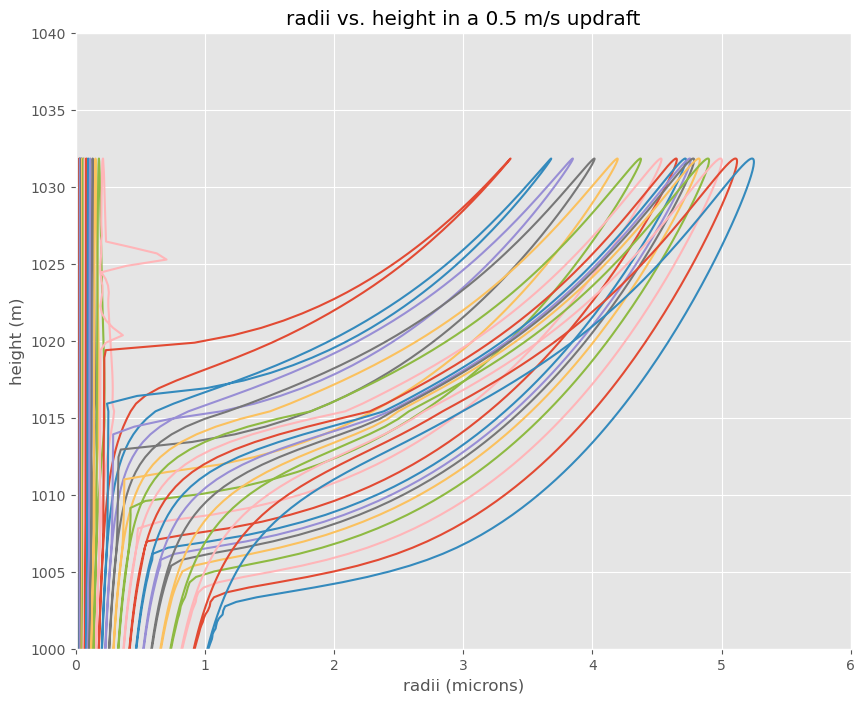

In [14]:
plt.style.use('ggplot')
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=[10,8])
for i in colnames[:-3]:
    ax.plot(df_output[i]*1.e6,df_output['z'],label=i)
out=ax.set(ylim=[1000,1040],xlim=[0,6],
       xlabel='radii (microns)',ylabel='height (m)',
              title='radii vs. height in a {} m/s updraft'.format(cloud_tup.wvel))

## Plot the parcel supersaturation

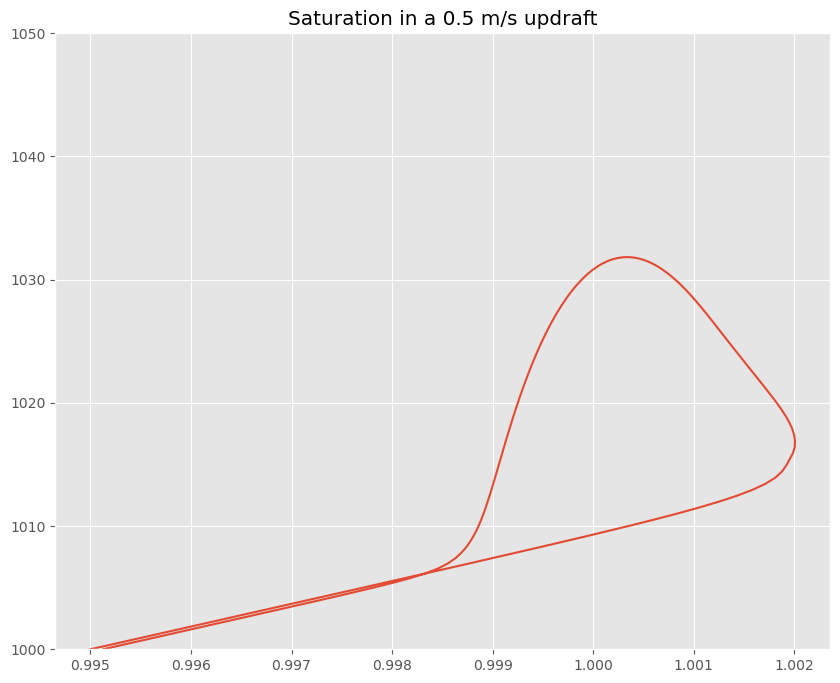

In [15]:
Svals = []
for index,row in df_output.iterrows():
    out_vec = row.values
    Svals.append(Scalc(out_vec,cloud_tup))
fig,ax = plt.subplots(1,1,figsize=[10,8])
ax.plot(Svals,df_output['z'])
out=ax.set(ylim=[1000,1050],title='Saturation in a {} m/s updraft'.format(cloud_tup.wvel))

## Worksheet Problem 1: oscilating updraft

Replace the constant updraft with an oscillating updraft that cycles between -0.5 and 0.5 m/s over a period of 200 seconds. Is droplet grow/evaporation a reversible process?

## Worksheet problem 2 -- calculating $r_l$ and $h_l$

Use [pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)  and the function rlcalc above to get the time history of the liquid water path

### simple example

1. we want to apply a function along columns (axis=1) rather than rows (axis=0)
2. we want to return the result as a new column in the dataframe, rather than a separate vector

In [16]:
def test_fun(row):
    #print(f"{row.name=}, {row=}")
    full_vec = row.to_numpy()
    drops = full_vec[:-3]
    rad_sum = np.sum(drops)
    row["testcol"] = rad_sum
    return row

In [17]:
def rlcalc(var_vec,ndist):
    """
    calculate the liquid water for the distribution

    the last  3 variables in var_vec are temperature, pressure and height (mks)

    Parameters
    ----------

    var_vec: vector(float)
           vector of values to be integrated
    cloud_top: namedtuple
           tuple of necessary coefficients
    """
    wl=ndist*(var_vec[:-3]**3.)
    wl=np.sum(wl)
    wl=wl*4./3.*np.pi*c.rhol
    #print(f"{wl=}")
    return wl

In [18]:
def hlcalc(var_vec,z0):
    var_vec = var_vec.to_numpy()
    temp,press,z,rl = var_vec[-4:]
    hlout = c.cpd*temp - c.lv0*rl + c.g0*(z - z0)
    #print(f"{(rl,temp,z,hlout)=}")
    row['hl'] = hlout
    return row
    #print(temp,press,z,rl)

In [19]:
def find_rl(row,ndist):
    var_vec = row.to_numpy()
    rl = rlcalc(var_vec,ndist)
    row['rl'] = rl
    return row

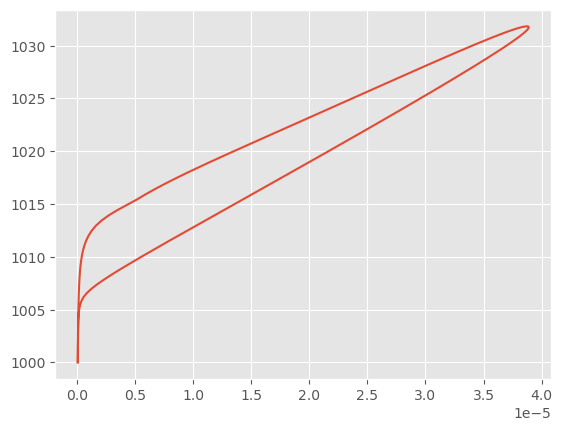

In [20]:
new_df =df_output.apply(find_rl,axis=1,args = (ndist,) )
fig,ax = plt.subplots(1,1)
ax.plot('rl','z',data = new_df);

In [21]:
new_df.columns

Index(['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10',
       'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20',
       'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'temp',
       'press', 'z', 'rl'],
      dtype='object')

### now add the rl column 

Note that you need the number distribution, which you can pass to the rlcalc function using the args parameter in apply

### repeat for liquid water static energy

How much $h_l = c_p T  - l_v r_l + gz$ change during the integration?

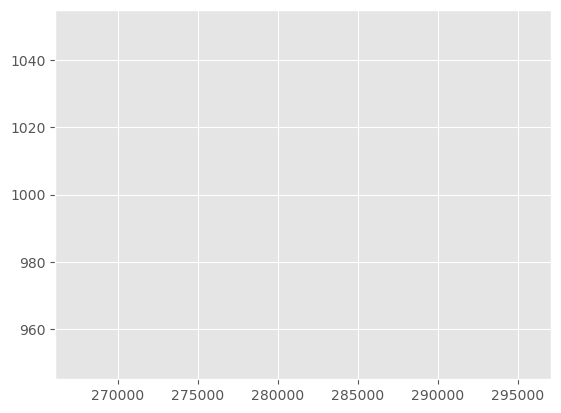

In [22]:
z0 = new_df['z'][0]
new_df2 = new_df.apply(hlcalc,args=(z0,),axis=1)
fig,ax = plt.subplots(1,1)
ax.plot('hl','z',data = new_df2);

In [23]:
new_df2.columns

Index(['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10',
       'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20',
       'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'temp',
       'press', 'z', 'hl'],
      dtype='object')